#### 1 - Localiza cada moeda, extraindo da imagem um array com cada uma das localizações
#### 2 - em cada recorte da imagem original, transforma em B&W, escala o recorte e extrai as features
#### 3 - passa cada um dos recortes para as MLP's e armazena o resultado de cada imagem
#### 4 - Avalia as probabilidades de cada resultado e informa o resultado com maior probabilidade como resposta

In [ ]:
###

In [116]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from skimage.color import rgb2gray
from joblib import dump, load
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


path_images = 'coin_images/train/5-c/'
coin_img = '1-c_2002_10.jpg'

### Implementação

In [118]:
class ImageProcessor:
    def __init__(self, size):
        self.size = size

    # Função para criar descritores de imagens utilizando HOG
    def create_features(self, image_str_img):
        
        # Se a entrada é uma string, assumimos que é um nome de arquivo
        if isinstance(image_str_img, str):
            # Carrega a imagem
            image = imread(image_str_img)
            try:
                # Carrega a imagem
                image = imread(image_str_img)
            except FileNotFoundError:
                print(f"Arquivo {image_str_img} não encontrado.")
                return None
            except OSError:
                print(f"Erro ao ler o arquivo {image_str_img}.")
                return None
            # Caso contrário, assumimos que é uma imagem
        else:
            image = image_str_img

        # Se a imagem não for em escala de cinza, converte para escala de cinza
        if len(image.shape) > 2:
            image = rgb2gray(image)

        # Redimensiona a imagem para um tamanho fixo
        image = resize(image, self.size)

        # Calcula o descritor HOG para a imagem
        fd = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)

        return fd

    # Função para processar imagens em um diretório e extrair características
    def process_images(self, dir_name):
        features_dict = {}

        # Para cada arquivo no diretório
        for file_name in os.listdir(dir_name):

            if (file_name.endswith('.png') or file_name.endswith('.jpg')):

                # Extrai características da imagem
                features = self.create_features(dir_name + file_name)

                if features is None:
                    continue

                # Armazena as características no dicionário com o nome do arquivo como chave
                features_dict[file_name] = features
                
        return features_dict
    
    def detect_coins(self, image, classifier):
        # Converte a imagem para escala de cinza
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Suaviza a imagem
        #gray = cv2.medianBlur(gray, 5)

        # Detecta círculos na imagem
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 60, param1=150, param2=250, minRadius=0, maxRadius=0)
        if circles is not None:
            circles = np.uint16(np.around(circles))
        else:
            circles = []

        coinCount = 0
        for i in circles[0,:]:
            # Verifica se o círculo está dentro dos limites da imagem
            if i[0]-i[2] >= 0 and i[1]-i[2] >= 0 and i[0]+i[2] <= gray.shape[1] and i[1]+i[2] <= gray.shape[0]:
                # Obtém a região de interesse da imagem
                roi = gray[i[1]-i[2]:i[1]+i[2], i[0]-i[2]:i[0]+i[2]]

                # Verifica se a ROI não está vazia
                if roi.size > 0:
                    # Redimensiona a região de interesse para o tamanho esperado pelo classificador
                    roi = cv2.resize(roi, self.size)
                    #cv2.imshow('Coins', image)
                    #print("ROI: ", roi)
                    
                    # Extrai as características da região de interesse
                    features = self.create_features(roi)

                    #print("Features: ", features)

                    # Classifica a região de interesse
                    label = classifier.predict([features])

                    # Desenha o círculo na imagem
                    cv2.circle(image, (i[0], i[1]), i[2], (0, 0, 255), 2)

                    # Desenha o rótulo na imagem
                    cv2.rectangle(image, (i[0] - 30 , i[1] - 25), (i[0] + 25, i[1] + 1), (171, 219, 227), cv2.FILLED)
                    cv2.putText(image, label[0].replace('-',''), (i[0] - 20, i[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (168, 129, 50), 1, cv2.LINE_AA, False)
                    

                    # Incrementa o contador de moedas
                    coinCount += 1
        
            # Desenha o contador de moedas na imagem
        textSize, _ = cv2.getTextSize(f'Total de moedas: {coinCount}', cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        textX = image.shape[1] - textSize[0] - 20
        textY = image.shape[0] - 20
        
        cv2.rectangle(image, (textX - 8, textY - textSize[1] - 8), (textX + textSize[0] + 8, textY + 8), (171, 219, 227), cv2.FILLED)
        cv2.putText(image, f'Total de moedas: {coinCount}', (textX, textY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (168, 129, 50), 1, cv2.LINE_AA, False)

        # Mostra a imagem
        cv2.imshow('Detected Coins', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()



In [119]:
class ModelData:
    def __init__(self, name, path, path_sufix='', test_size=0.2, image_size=(64, 64)) -> None:
        self.name = name
        self.path = path
        self.path_sufix = path_sufix
        self.test_size = test_size
        self.classifierMLP = None
        self.classifierSVM = None
        self.imageProcessor = ImageProcessor(image_size)
        self.__create_model_data()

    def __create_model_data(self):
        features = []
        labels = []

        for label in ['1-r', '5-c', '10-c', '25-c', '50-c']:
            temp_path = os.path.join(self.path, label, self.path_sufix)
            print(temp_path)
            
            features_dict = self.imageProcessor.process_images(temp_path)
            temp_labels = (len(features_dict.keys()) * (' ' + label)).strip().split(' ')
            # Converte o dicionário de características para uma lista, mantendo a mesma ordem dos rótulos.
            temp_features = [features_dict[file_name] for file_name in sorted(features_dict.keys())]

            features.extend(temp_features)
            labels.extend(temp_labels)

        self.features_train, self.features_test, self.labels_train, self.labels_test = train_test_split(features, labels, test_size=self.test_size, random_state=42)

    def train_classifier_SVM(self, load_model = False):
        print(f'Creating SVM classifier... {self.name}')
        if load_model:
            clf = load(f'svm_model_{self.name}.joblib')
        else:
            clf = svm.SVC(gamma='scale')
            self.classifierSVM = self.__train_classifier(clf, f'svm_model_{self.name}.joblib')

    def train_classifier_MLP(self, load_model = False):
        print(f'Creating MLP classifier... {self.name}')
        if load_model:
            clf = load(f'mlp_model_{self.name}.joblib')
        else:
            clf = MLPClassifier(hidden_layer_sizes=[128, 1024, 64], activation='logistic', max_iter=10000)
            self.classifierMLP = self.__train_classifier(clf, f'mlp_model_{self.name}.joblib')
            
    def __train_classifier(self, classifier, file_name):
        print('Training classifier...')
        classifier.fit(self.features_train, self.labels_train)
        dump(classifier, file_name)

        return classifier

    def eval_classifier(self, classifier):
        labels_pred = classifier.predict(self.features_test)
        
        # Calcular métricas
        accuracy = accuracy_score(self.labels_test, labels_pred)
        precision = precision_score(self.labels_test, labels_pred, average='weighted')
        recall = recall_score(self.labels_test, labels_pred, average='weighted')
        f1 = f1_score(self.labels_test, labels_pred, average='weighted')

        print('Acurácia:', accuracy)
        print('Precisão:', precision)
        print('Recall:', recall)
        print('F1 Score:', f1)

        # Matriz de confusão
        cm = confusion_matrix(self.labels_test, labels_pred)
        print('Matriz de confusão:\n', cm)

        results = {
            'name': self.name,
            'type': classifier.__class__.__name__,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

        return results



### Criação e treinamento dos modelos

In [126]:
#Cria os dados para treinamento e teste do modelo com variacoes no tamanho da imagem para o hog descriptor
models = {
    'coinsData_64': ModelData('coins_64', 'coin_images/train/', '', 0.2, (64, 64)),
    'coinsData_128': ModelData('coins_128', 'coin_images/train/', '', 0.2, (128, 128)),
    'coinsData_256': ModelData('coins_256', 'coin_images/train/', '', 0.2, (256, 256)),
    'coinsData_512': ModelData('coins_512', 'coin_images/train/', '', 0.2, (512, 512)),
    'bwData_64' : ModelData('coins_bw_64', 'coin_images/train/', 'bw/', 0.2, (64, 64)),
    'bwData_128': ModelData('coins_bw_128', 'coin_images/train/', 'bw/', 0.2, (128, 128)),
    'bwData_256': ModelData('coins_bw_256', 'coin_images/train/', 'bw/', 0.2, (256, 256))
}

coin_images/train/1-r\
coin_images/train/5-c\
coin_images/train/10-c\
coin_images/train/25-c\
coin_images/train/50-c\
coin_images/train/1-r\
coin_images/train/5-c\
coin_images/train/10-c\
coin_images/train/25-c\
coin_images/train/50-c\
coin_images/train/1-r\
coin_images/train/5-c\
coin_images/train/10-c\
coin_images/train/25-c\
coin_images/train/50-c\
coin_images/train/1-r\
coin_images/train/5-c\
coin_images/train/10-c\
coin_images/train/25-c\
coin_images/train/50-c\
coin_images/train/1-r\bw/
coin_images/train/5-c\bw/
coin_images/train/10-c\bw/
coin_images/train/25-c\bw/
coin_images/train/50-c\bw/
coin_images/train/1-r\bw/
coin_images/train/5-c\bw/
coin_images/train/10-c\bw/
coin_images/train/25-c\bw/
coin_images/train/50-c\bw/
coin_images/train/1-r\bw/
coin_images/train/5-c\bw/
coin_images/train/10-c\bw/
coin_images/train/25-c\bw/
coin_images/train/50-c\bw/


In [127]:
results = pd.DataFrame(columns=['name', 'type', 'accuracy', 'precision', 'recall', 'f1'])

for model in models.values():
    print(f'Training model {model.name}')
    model.train_classifier_MLP()
    results = results.append(model.eval_classifier(model.classifierMLP), ignore_index=True)

    model.train_classifier_SVM()
    results = results.append(model.eval_classifier(model.classifierSVM), ignore_index=True)
    print()

Training model coins_64
Creating MLP classifier... coins_64
Training classifier...
Acurácia: 0.6150442477876106
Precisão: 0.6276783303239473
Recall: 0.6150442477876106
F1 Score: 0.6131970491306676
Matriz de confusão:
 [[29  4  2  0  0]
 [ 2 38  2  4  8]
 [ 0  4 22  4  8]
 [ 1  8  9 41  2]
 [ 1 22  6  0  9]]
Creating SVM classifier... coins_64
Training classifier...
Acurácia: 0.7477876106194691
Precisão: 0.7651423280932225
Recall: 0.7477876106194691
F1 Score: 0.7461925203338379
Matriz de confusão:
 [[28  3  2  2  0]
 [ 2 45  3  4  0]
 [ 0  1 28  4  5]
 [ 0  3  8 50  0]
 [ 0 12  8  0 18]]

Training model coins_128
Creating MLP classifier... coins_128
Training classifier...


C:\Users\crist\AppData\Local\Temp\ipykernel_1964\2889229676.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierMLP), ignore_index=True)
C:\Users\crist\AppData\Local\Temp\ipykernel_1964\2889229676.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierSVM), ignore_index=True)


Acurácia: 0.8805309734513275
Precisão: 0.8818635615095793
Recall: 0.8805309734513275
F1 Score: 0.8804593140347995
Matriz de confusão:
 [[32  0  0  2  1]
 [ 0 50  2  1  1]
 [ 0  2 30  3  3]
 [ 0  2  3 56  0]
 [ 0  2  2  3 31]]
Creating SVM classifier... coins_128
Training classifier...
Acurácia: 0.8805309734513275
Precisão: 0.8826072030701781
Recall: 0.8805309734513275
F1 Score: 0.88058102659899
Matriz de confusão:
 [[32  1  0  0  2]
 [ 0 44  5  2  3]
 [ 0  1 34  3  0]
 [ 0  0  2 58  1]
 [ 0  5  1  1 31]]

Training model coins_256
Creating MLP classifier... coins_256
Training classifier...


C:\Users\crist\AppData\Local\Temp\ipykernel_1964\2889229676.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierMLP), ignore_index=True)
C:\Users\crist\AppData\Local\Temp\ipykernel_1964\2889229676.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierSVM), ignore_index=True)


Acurácia: 0.9690265486725663
Precisão: 0.9703094868785798
Recall: 0.9690265486725663
F1 Score: 0.9691053932691058
Matriz de confusão:
 [[32  0  1  1  1]
 [ 0 52  0  0  2]
 [ 0  0 37  0  1]
 [ 0  0  0 61  0]
 [ 0  1  0  0 37]]
Creating SVM classifier... coins_256
Training classifier...


C:\Users\crist\AppData\Local\Temp\ipykernel_1964\2889229676.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierMLP), ignore_index=True)


Acurácia: 0.9424778761061947
Precisão: 0.9479527143045832
Recall: 0.9424778761061947
F1 Score: 0.9410597766581624
Matriz de confusão:
 [[32  2  0  1  0]
 [ 0 53  0  1  0]
 [ 0  0 38  0  0]
 [ 0  0  0 61  0]
 [ 0  5  0  4 29]]

Training model coins_512
Creating MLP classifier... coins_512
Training classifier...


C:\Users\crist\AppData\Local\Temp\ipykernel_1964\2889229676.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierSVM), ignore_index=True)


Acurácia: 0.9247787610619469
Precisão: 0.9305653841173133
Recall: 0.9247787610619469
F1 Score: 0.9249825022188967
Matriz de confusão:
 [[32  0  0  3  0]
 [ 0 50  0  0  4]
 [ 0  0 31  7  0]
 [ 0  0  2 58  1]
 [ 0  0  0  0 38]]
Creating SVM classifier... coins_512
Training classifier...


C:\Users\crist\AppData\Local\Temp\ipykernel_1964\2889229676.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierMLP), ignore_index=True)


Acurácia: 0.9336283185840708
Precisão: 0.9423566492908231
Recall: 0.9336283185840708
F1 Score: 0.9342980644290797
Matriz de confusão:
 [[32  0  0  3  0]
 [ 0 51  0  3  0]
 [ 0  0 35  3  0]
 [ 0  0  0 61  0]
 [ 0  3  0  3 32]]

Training model coins_bw_64
Creating MLP classifier... coins_bw_64
Training classifier...


C:\Users\crist\AppData\Local\Temp\ipykernel_1964\2889229676.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierSVM), ignore_index=True)
c:\Users\crist\.conda\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\crist\AppData\Local\Temp\ipykernel_1964\2889229676.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierMLP), ignore_index=True)
C:\Users\crist\AppData\Local\Temp\ipykernel_1964\2889229676.py:9: FutureWarning: The frame.append method is depreca

Acurácia: 0.26991150442477874
Precisão: 0.07285222022084736
Recall: 0.26991150442477874
F1 Score: 0.11473590083562023
Matriz de confusão:
 [[ 0  0  0 35  0]
 [ 0  0  0 54  0]
 [ 0  0  0 38  0]
 [ 0  0  0 61  0]
 [ 0  0  0 38  0]]
Creating SVM classifier... coins_bw_64
Training classifier...
Acurácia: 0.6902654867256637
Precisão: 0.7010588708532488
Recall: 0.6902654867256637
F1 Score: 0.6798269777577249
Matriz de confusão:
 [[18  0  3 12  2]
 [ 1 42  3  4  4]
 [ 0  1 27  6  4]
 [ 0  3  4 54  0]
 [ 2  9  3  9 15]]

Training model coins_bw_128
Creating MLP classifier... coins_bw_128
Training classifier...
Acurácia: 0.6592920353982301
Precisão: 0.6717379191874563
Recall: 0.6592920353982301
F1 Score: 0.663380933147645
Matriz de confusão:
 [[30  0  2  3  0]
 [ 0 30  3  4 17]
 [ 0  7 24  4  3]
 [ 1  1  3 48  8]
 [ 0 11  2  8 17]]
Creating SVM classifier... coins_bw_128
Training classifier...
Acurácia: 0.7743362831858407
Precisão: 0.7739006724701553
Recall: 0.7743362831858407
F1 Score: 0.76867

C:\Users\crist\AppData\Local\Temp\ipykernel_1964\2889229676.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierMLP), ignore_index=True)
C:\Users\crist\AppData\Local\Temp\ipykernel_1964\2889229676.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierSVM), ignore_index=True)


Acurácia: 0.9292035398230089
Precisão: 0.9305238367113903
Recall: 0.9292035398230089
F1 Score: 0.9294789908550376
Matriz de confusão:
 [[32  0  0  3  0]
 [ 0 49  1  0  4]
 [ 0  2 36  0  0]
 [ 0  2  0 59  0]
 [ 0  3  1  0 34]]
Creating SVM classifier... coins_bw_256
Training classifier...


C:\Users\crist\AppData\Local\Temp\ipykernel_1964\2889229676.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierMLP), ignore_index=True)


Acurácia: 0.9646017699115044
Precisão: 0.9669764717505751
Recall: 0.9646017699115044
F1 Score: 0.9641404655763642
Matriz de confusão:
 [[32  0  0  3  0]
 [ 0 54  0  0  0]
 [ 0  0 38  0  0]
 [ 0  0  0 61  0]
 [ 0  3  0  2 33]]



C:\Users\crist\AppData\Local\Temp\ipykernel_1964\2889229676.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model.eval_classifier(model.classifierSVM), ignore_index=True)


### Resultados

In [128]:
#medidas de avaliação dos classificadores conforme o tipo e tamanho de imagem
results

,name,type,accuracy,precision,recall,f1
0,coins_64,MLPClassifier,0.615044,0.627678,0.615044,0.613197
1,coins_64,SVC,0.747788,0.765142,0.747788,0.746193
2,coins_128,MLPClassifier,0.880531,0.881864,0.880531,0.880459
3,coins_128,SVC,0.880531,0.882607,0.880531,0.880581
4,coins_256,MLPClassifier,0.969027,0.970309,0.969027,0.969105
5,coins_256,SVC,0.942478,0.947953,0.942478,0.941060
6,coins_512,MLPClassifier,0.924779,0.930565,0.924779,0.924983
7,coins_512,SVC,0.933628,0.942357,0.933628,0.934298
8,coins_bw_64,MLPClassifier,0.269912,0.072852,0.269912,0.114736
9,coins_bw_64,SVC,0.690265,0.701059,0.690265,0.679827


In [96]:
# Cria o classificador MLP. 
# A lista [64, 64] define duas camadas ocultas com 64 neurônios cada.
# A função de ativação 'relu' é a função padrão.
# A taxa máxima de iterações (max_iter) é definida como 2000.
mlp = MLPClassifier(hidden_layer_sizes=[128, 1024, 64], activation='logistic', max_iter=10000)

# Treina o classificador MLP.
mlp.fit(coinsData_256.features_train, coinsData_256.labels_train)
print(mlp.score(coinsData_256.features_test, coinsData_256.labels_test))



0.9646017699115044


In [137]:
model = models['coinsData_256']

clf = model.classifierMLP
image = cv2.imread('coin_images/test/test_3.jpeg')

model.imageProcessor.detect_coins(image, clf)


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


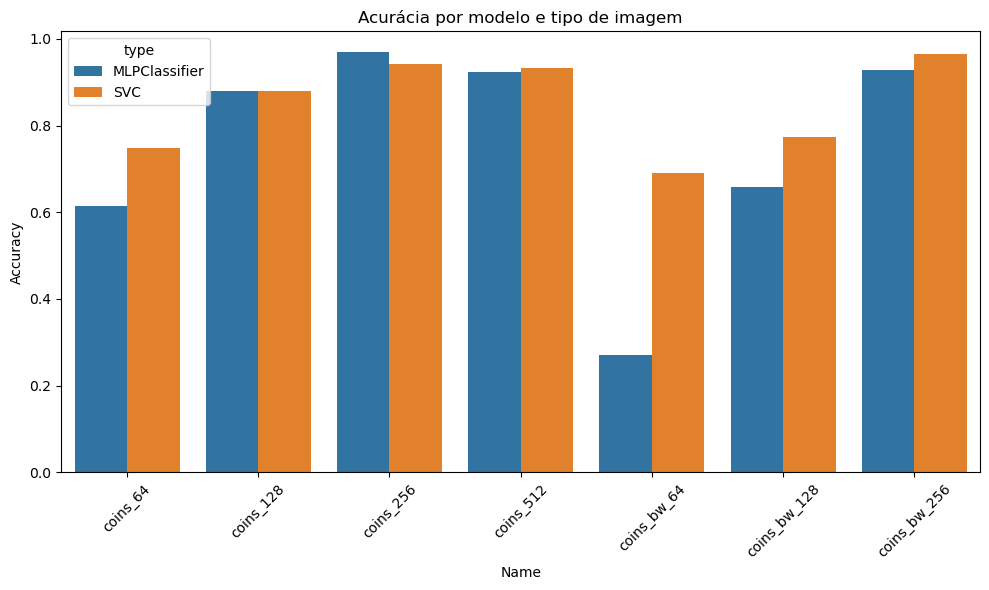

In [132]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que seus dados estejam em um DataFrame chamado df

plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='accuracy', hue='type', data=results)
plt.title('Acurácia por modelo e tipo de imagem')
plt.ylabel('Accuracy')
plt.xlabel('Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
